In [1]:
%load_ext autoreload
%autoreload 2

# Unbiased ECMWF

Here we propose a small model which is a debiased ECMWF forecast according to the data we have.
The plan is
* Compute the bias between the ECMWF model and the observations
* Make a debiased model
* Turn this model into a probabilistic forecast
For this notebook we want to do it on precipitation and temperature, for weeks 1-2, 3-4, and 5-6.

In [2]:
import dask
import dask.array as da
import dask.distributed
import datetime
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pathlib
import scipy.stats
import typing
import xarray as xr
import xskillscore as xs

In [3]:
from crims2s.dask import create_dask_cluster
from crims2s.util import fix_dataset_dims

In [4]:
INPUT_TRAIN = '***BASEDIR***training-input/0.3.0/netcdf'
OBSERVATIONS = '***BASEDIR***/processed/training-output-reference/'
BENCHNMARK = '***BASEDIR***training-output-benchmark/'

## Boost dask cluster

In [5]:
cluster = create_dask_cluster()
cluster.scale(jobs=2)

In [6]:
client = dask.distributed.Client(cluster)

In [7]:
client

Client Scheduler: tcp://10.20.40.91:42915 Dashboard: http://10.20.40.91:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Generic Functions

In [8]:
def extract_train_validation_from_lead_time(xr_data) -> typing.Tuple:
    xr_data_sub_train = xr_data.sel(forecast_year=slice(None, 2018))
    xr_data_sub_val = xr_data.sel(forecast_year=slice(2019, None))
    
    return xr_data_sub_train, xr_data_sub_val

In [9]:
def compute_and_correct_bias(data_center_train, data_center_val, obs_train):
    
    bias = (obs_train - data_center_train).mean(dim=['lead_time', 'forecast_year'])
    corrected_bias = data_center_val + bias
    
    return bias, corrected_bias

In [10]:
def add_biweekly_dim(dataset):
    weeklys = []
    for s in [slice('0D', '13D'), slice('14D', '27D'), slice('28D', '41D')]:
        weekly_forecast = dataset.sel(lead_time=s)

        first_lead = pd.to_timedelta(weekly_forecast.lead_time[0].item())

        weekly_forecast = weekly_forecast.expand_dims(dim='biweekly_forecast').assign_coords(biweekly_forecast=[first_lead])
        weekly_forecast = weekly_forecast.assign_coords(lead_time=(weekly_forecast.lead_time - first_lead))
        weeklys.append(weekly_forecast)
        
    return xr.concat(weeklys, dim='biweekly_forecast').transpose('forecast_year', 'forecast_dayofyear', 'biweekly_forecast', ...)

## Read data

### ECMWF Temperature

In [11]:
CENTER = 'ecmwf'
FIELD = 'tp'

In [12]:
input_path = pathlib.Path(INPUT_TRAIN)

In [14]:
input_files_tp = sorted([f for f in input_path.iterdir() if CENTER in f.stem and FIELD in f.stem])

In [15]:
input_files_tp[:10]

[PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-tp-20200102.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-tp-20200109.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-tp-20200116.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-tp-20200123.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-tp-20200130.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-tp-20200206.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-tp-20200213.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-tp-20200220.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-tp-20200227.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-tp-20200305.nc')]

In [18]:
ecmwf_tp_raw = xr.open_mfdataset(input_files_tp, preprocess=fix_dataset_dims)
ecmwf_tp_raw = ecmwf_tp_raw.assign_coords(lead_time=ecmwf_tp_raw.lead_time - ecmwf_tp_raw.lead_time[0])
# Fix the lead times by starting them at 0. To be validated with the organizers.

In [19]:
ecmwf_tp = add_biweekly_dim(ecmwf_tp_raw)

In [20]:
ecmwf_tp

,Array,Chunk
Bytes,347.81 kiB,2.19 kiB
Shape,"(20, 53, 3, 14)","(20, 1, 1, 14)"
Count,846 Tasks,159 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,52.98 GiB,341.20 MiB
Shape,"(20, 53, 3, 11, 14, 121, 240)","(20, 1, 1, 11, 14, 121, 240)"
Count,901 Tasks,159 Chunks
Type,float32,numpy.ndarray


### Observations

In [21]:
obs_path = pathlib.Path(OBSERVATIONS)
obs_files = [f for f in obs_path.iterdir() if 'tp' in f.stem]

In [22]:
obs_files[:4]

[PosixPath('***BASEDIR***/processed/training-output-reference/obs_tp_forecast_shape_121.nc'),
 PosixPath('***BASEDIR***/processed/training-output-reference/obs_tp_forecast_shape_310.nc'),
 PosixPath('***BASEDIR***/processed/training-output-reference/obs_tp_forecast_shape_079.nc'),
 PosixPath('***BASEDIR***/processed/training-output-reference/obs_tp_forecast_shape_009.nc')]

In [25]:
obs_tp_raw = xr.open_mfdataset(obs_files)
obs_tp_raw = obs_tp_raw.assign_coords(lead_time=obs_tp_raw.lead_time - obs_tp_raw.lead_time[0])

In [26]:
obs_tp = add_biweekly_dim(obs_tp_raw)

In [27]:
obs_tp

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 3, forecast_dayofyear: 53, forecast_year: 20, latitude: 121, lead_time: 14, longitude: 240)
Coordinates:
  * lead_time           (lead_time) timedelta64[ns] 0 days 1 days ... 13 days
    valid_time          (forecast_year, forecast_dayofyear, biweekly_forecast, lead_time) datetime64[ns] dask.array<chunksize=(20, 1, 1, 14), meta=np.ndarray>
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_time       (forecast_year, forecast_dayofyear) datetime64[ns] dask.array<chunksize=(20, 1), meta=np.ndarray>
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2017 2018 2019
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 0 days ... 28 days
Data variables:
    tp                  (forecast_year, forecast_dayofyear, biweekly_forecast, lead_time, latitude, longitude) float32 dask.array<chunksize=(20, 1, 1, 14, 121, 240), meta=np.ndarray>
Attributes:
    source_dataset_name:  NOAA NCEP CPC UNIFIED_PRCP GAUGE_BASED GLOBAL v1p0 ...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile
    function:             climetlab_s2s_ai_challenge.extra.forecast_like_obse...

For precipitation we first have to take the biweekly total precip. We can't compute the difference directly on the daily forecasts.

In [32]:
ecmwf_tp = ecmwf_tp.isel(lead_time=-1) - ecmwf_tp.isel(lead_time=0)

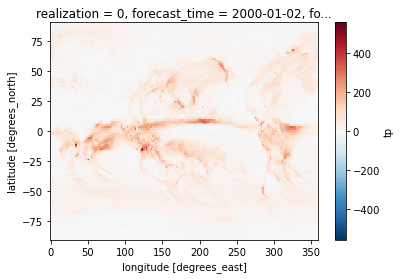

In [36]:
ecmwf_tp.isel(biweekly_forecast=1, forecast_dayofyear=0, forecast_year=0, realization=0).compute().tp.plot()

In [37]:
obs_tp = obs_tp.isel(lead_time=-1) - obs_tp.isel(lead_time=0)

In [38]:
ecmwf_tp_train, ecmwf_tp_val = extract_train_validation_from_lead_time(ecmwf_tp)

In [39]:
obs_tp_train, obs_tp_val = extract_train_validation_from_lead_time(obs_tp)

In [40]:
ecmwf_tp_train

,Array,Chunk
Bytes,3.60 GiB,23.15 MiB
Shape,"(19, 53, 3, 11, 121, 240)","(19, 1, 1, 11, 121, 240)"
Count,1537 Tasks,159 Chunks
Type,float32,numpy.ndarray


In [41]:
obs_tp_train

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 3, forecast_dayofyear: 53, forecast_year: 19, latitude: 121, longitude: 240)
Coordinates:
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_time       (forecast_year, forecast_dayofyear) datetime64[ns] dask.array<chunksize=(19, 1), meta=np.ndarray>
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2016 2017 2018
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 0 days ... 28 days
Data variables:
    tp                  (forecast_year, forecast_dayofyear, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(19, 1, 1, 121, 240), meta=np.ndarray>

## Debiasing

In [ ]:
ecmwf_tp_train

### Compute bias using training data

In [42]:
ecmwf_tp_bias = (obs_tp_train - ecmwf_tp_train).mean(dim=['forecast_year'])

In [43]:
ecmwf_tp_bias

,Array,Chunk
Bytes,193.75 MiB,1.22 MiB
Shape,"(53, 3, 121, 240, 11)","(1, 1, 121, 240, 11)"
Count,3922 Tasks,159 Chunks
Type,float32,numpy.ndarray


### Bias correct ECMWF

In [45]:
ecmwf_tp_val_corrected = ecmwf_tp_val + ecmwf_tp_bias

In [46]:
ecmwf_tp_val_corrected

,Array,Chunk
Bytes,193.75 MiB,1.22 MiB
Shape,"(1, 53, 3, 11, 121, 240)","(1, 1, 1, 11, 121, 240)"
Count,4558 Tasks,159 Chunks
Type,float32,numpy.ndarray


In [47]:
ecmwf_tp_val_corrected_comp = ecmwf_tp_val_corrected.compute()

## Turn into probabilistic forecast

### Get thresholds from train observations

In [50]:
obs_tp_train_thresholds = obs_tp_train.chunk({'forecast_year': -1}).quantile([0.33, 0.67], dim=['forecast_year'])

In [51]:
obs_tp_train_thresholds

,Array,Chunk
Bytes,70.46 MiB,453.75 kiB
Shape,"(2, 53, 3, 121, 240)","(2, 1, 1, 121, 240)"
Count,2226 Tasks,159 Chunks
Type,float64,numpy.ndarray


In [53]:
obs_tp_train_thresholds_comp = obs_tp_train_thresholds.compute()

### Compute p of thresholds according to the model

There are two ways to do this. 
We can either count the amount of members that are whithin each category.
Or compute a distribution of all the members of the model, and then compute the value of the CDF for each threshold.

Here we do it using the distribution method.

#### Compute a distribution of the members of the model

In [55]:
ecmwf_tp_val_corrected_mean = ecmwf_tp_val_corrected_comp.mean(dim=['realization'])
ecmwf_tp_val_corrected_std = ecmwf_tp_val_corrected_comp.std(dim=['realization'])

#### Compute the value of the CDF for each threshold

In [57]:
ecmwf_tp_val_corrected_mean

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 3, forecast_dayofyear: 53, forecast_year: 1, latitude: 121, longitude: 240)
Coordinates:
    forecast_time       (forecast_year, forecast_dayofyear) datetime64[ns] 20...
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2019
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 0 days ... 28 days
Data variables:
    tp                  (forecast_year, forecast_dayofyear, biweekly_forecast, latitude, longitude) float32 ...

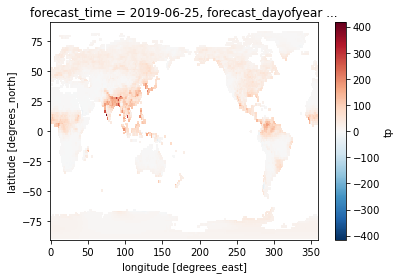

In [59]:
ecmwf_tp_val_corrected_mean.isel(biweekly_forecast=1, forecast_dayofyear=25).tp.plot()

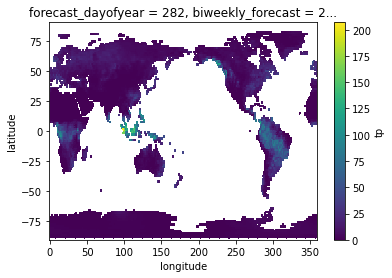

In [62]:
obs_tp_train_thresholds_comp.isel(biweekly_forecast=2, quantile=0, forecast_dayofyear=40).tp.plot()

In [65]:
def make_probabilistic(forecast, thresholds):   
    loc = forecast.mean(dim=['realization']).compute().tp
    scale = forecast.std(dim=['realization']).compute().tp
    
    cdfs = xr.apply_ufunc(scipy.stats.norm.cdf, thresholds.tp, dask='allowed', kwargs={'loc': loc, 'scale': scale})
    
    below = cdfs.isel(quantile=0).drop_vars('quantile')
    normal = (cdfs.isel(quantile=1) - cdfs.isel(quantile=0))
    above = xr.ones_like(normal) - cdfs.isel(quantile=1).drop_vars('quantile')
    
    return xr.Dataset({'tp': xr.concat([below, normal, above], 'category').assign_coords(category=['below normal', 'near normal', 'above normal'])})

In [66]:
val_probabilistic_forecast = make_probabilistic(ecmwf_tp_val_corrected_comp, obs_tp_train_thresholds_comp)

***REMOVED***/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1919: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
***REMOVED***/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1919: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [68]:
val_probabilistic_forecast = val_probabilistic_forecast.expand_dims('forecast_year').assign_coords(forecast_year=ecmwf_tp_val_corrected_comp.forecast_year)

In [69]:
#val_probabilistic_forecast = val_probabilistic_forecast.assign_coords(valid_time=ecmwf_t2m_val_corrected_comp.valid_time)

In [70]:
val_probabilistic_forecast.biweekly_forecast.data

array([               0, 1209600000000000, 2419200000000000],
      dtype='timedelta64[ns]')

In [72]:
val_probabilistic_forecast

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 3, category: 3, forecast_dayofyear: 53, forecast_year: 1, latitude: 121, longitude: 240)
Coordinates:
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 0 days ... 28 days
  * category            (category) <U12 'below normal' ... 'above normal'
  * forecast_year       (forecast_year) int64 2019
Data variables:
    tp                  (forecast_year, category, forecast_dayofyear, biweekly_forecast, latitude, longitude) float64 ...

In [73]:
val_probabilistic_forecast = val_probabilistic_forecast.rename_dims({'biweekly_forecast': 'lead_time'}).assign_coords(lead_time=val_probabilistic_forecast.biweekly_forecast.data)

In [74]:
val_probabilistic_forecast

<xarray.Dataset>
Dimensions:             (category: 3, forecast_dayofyear: 53, forecast_year: 1, latitude: 121, lead_time: 3, longitude: 240)
Coordinates:
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
    biweekly_forecast   (lead_time) timedelta64[ns] 0 days 14 days 28 days
  * category            (category) <U12 'below normal' ... 'above normal'
  * forecast_year       (forecast_year) int64 2019
  * lead_time           (lead_time) timedelta64[ns] 0 days 14 days 28 days
Data variables:
    tp                  (forecast_year, category, forecast_dayofyear, lead_time, latitude, longitude) float64 ...

In [75]:
val_probabilistic_forecast.to_netcdf('***BASEDIR***/test_tp_forecast.nc')

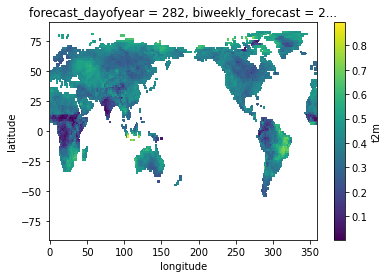

In [166]:
val_probabilistic_forecast.isel(category=2, forecast_dayofyear=40, biweekly_forecast=2).plot()

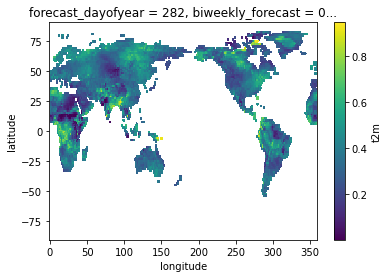

In [167]:
val_probabilistic_forecast.isel(category=1, forecast_dayofyear=40, biweekly_forecast=0).plot()

### Sanity check

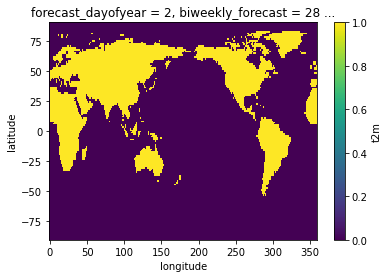

In [171]:
val_probabilistic_forecast.sum(dim='category').isel(forecast_dayofyear=0, biweekly_forecast=2).plot()

## Make submission file out of it

In [186]:
val_probabilistic_forecast_unfixed = xr.Dataset({'t2m': val_probabilistic_forecast.stack(forecast_time=['forecast_year', 'forecast_dayofyear'])})

In [187]:
val_probabilistic_forecast_unfixed.assign_coords()

<xarray.Dataset>
Dimensions:             (biweekly_forecast: 3, category: 3, forecast_time: 53, latitude: 121, longitude: 240)
Coordinates:
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 0 days ... 28 days
  * category            (category) <U12 'below normal' ... 'above normal'
  * forecast_time       (forecast_time) MultiIndex
  - forecast_year       (forecast_time) int64 2019 2019 2019 ... 2019 2019 2019
  - forecast_dayofyear  (forecast_time) int64 2 9 16 23 30 ... 345 352 359 366
Data variables:
    t2m                 (category, biweekly_forecast, latitude, longitude, forecast_time) float64 ...

In [ ]:
forecast_times = []
for 